In [5]:
import pandas as pd

In [2]:
#load all the data
agency = pd.read_csv('/Users/anoushkaanand/Documents/Data Analysis/problem-statements/metro-optimization/DMRC_GTFS/agency.txt')
calendar = pd.read_csv('/Users/anoushkaanand/Documents/Data Analysis/problem-statements/metro-optimization/DMRC_GTFS/calendar.txt')
routes = pd.read_csv('/Users/anoushkaanand/Documents/Data Analysis/problem-statements/metro-optimization/DMRC_GTFS/routes.txt')
shapes = pd.read_csv('/Users/anoushkaanand/Documents/Data Analysis/problem-statements/metro-optimization/DMRC_GTFS/shapes.txt')
stop_times = pd.read_csv('/Users/anoushkaanand/Documents/Data Analysis/problem-statements/metro-optimization/DMRC_GTFS/stop_times.txt')
stops = pd.read_csv('/Users/anoushkaanand/Documents/Data Analysis/problem-statements/metro-optimization/DMRC_GTFS/stops.txt')
trips = pd.read_csv('/Users/anoushkaanand/Documents/Data Analysis/problem-statements/metro-optimization/DMRC_GTFS/trips.txt')

In [3]:
data_overviews = {
    "agency": agency.head(),
    "calendar": calendar.head(),
    "routes": routes.head(),
    "shapes": shapes.head(),
    "stop_times": stop_times.head(),
    "stops": stops.head(),
    "trips": trips.head()
}

In [4]:
data_overviews

{'agency':   agency_id                   agency_name                      agency_url  \
 0      DMRC  Delhi Metro Rail Corporation  http://www.delhimetrorail.com/   
 
   agency_timezone  agency_lang  agency_phone  agency_fare_url  agency_email  
 0    Asia/Kolkata          NaN           NaN              NaN           NaN  ,
 'calendar':   service_id  monday  tuesday  wednesday  thursday  friday  saturday  sunday  \
 0    weekday       1        1          1         1       1         0       0   
 1   saturday       0        0          0         0       0         1       0   
 2     sunday       0        0          0         0       0         0       1   
 
    start_date  end_date  
 0    20190101  20251231  
 1    20190101  20251231  
 2    20190101  20251231  ,
 'routes':    route_id  agency_id route_short_name  \
 0        33        NaN           R_SP_R   
 1        31        NaN           G_DD_R   
 2        29        NaN           P_MS_R   
 3        12        NaN             M_JB

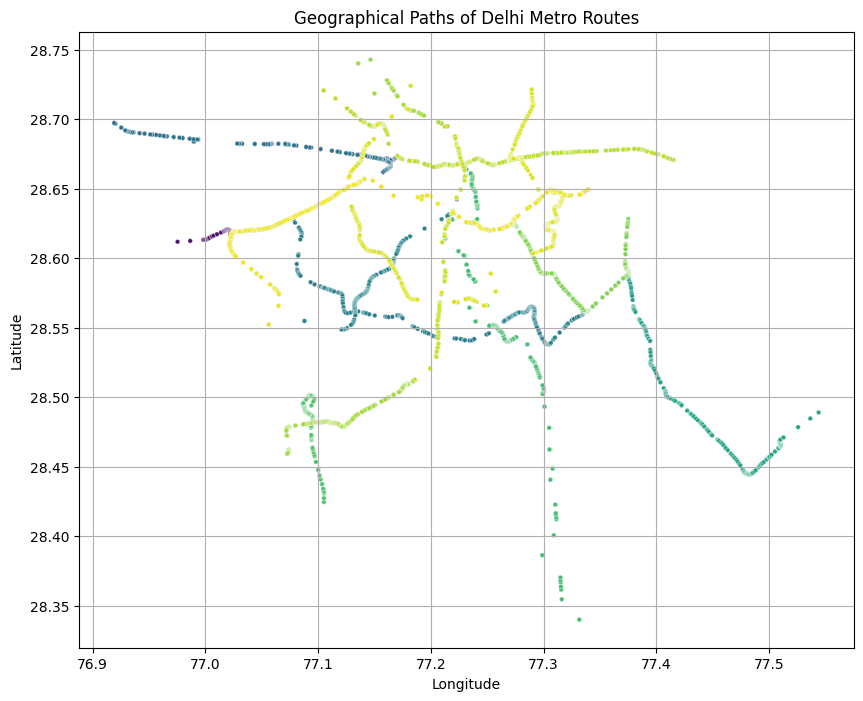

In [6]:
#Geographical plot of paths of different routes
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.scatterplot(x='shape_pt_lon', y='shape_pt_lat', hue='shape_id', data=shapes, palette = 'viridis', s=10, legend=None)
plt.title('Geographical Paths of Delhi Metro Routes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

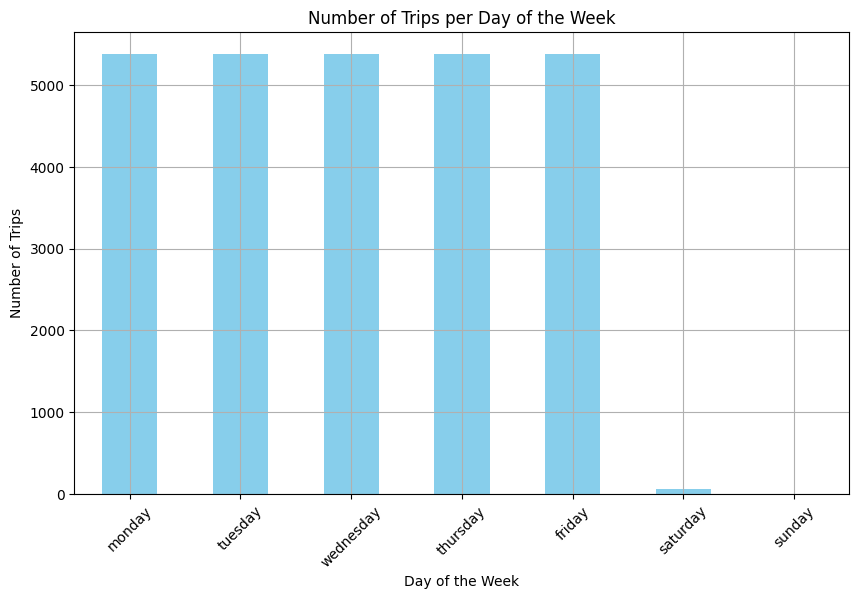

In [7]:
trips_calendar = pd.merge(trips, calendar, on='service_id', how = 'left')
trip_counts = trips_calendar[['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']].sum()

# Plotting
plt.figure(figsize=(10, 6))
trip_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Trips per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

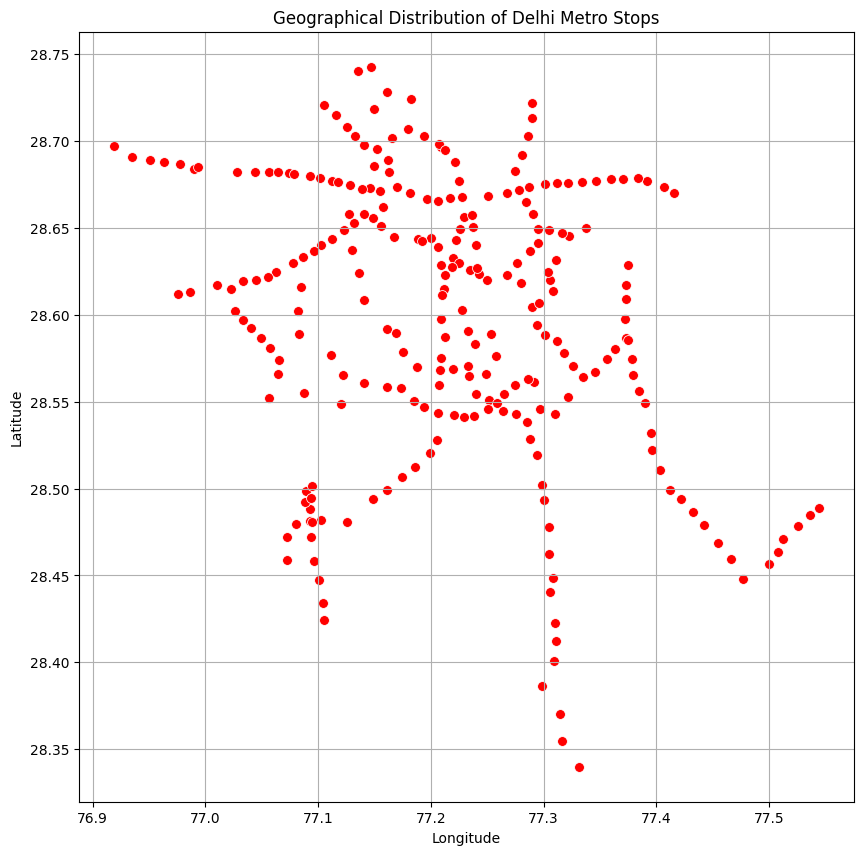

In [8]:
# plotting the locations of the stops
plt.figure(figsize=(10, 10))
sns.scatterplot(x='stop_lon', y='stop_lat', data=stops, color='red', s=50, marker='o')
plt.title('Geographical Distribution of Delhi Metro Stops')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

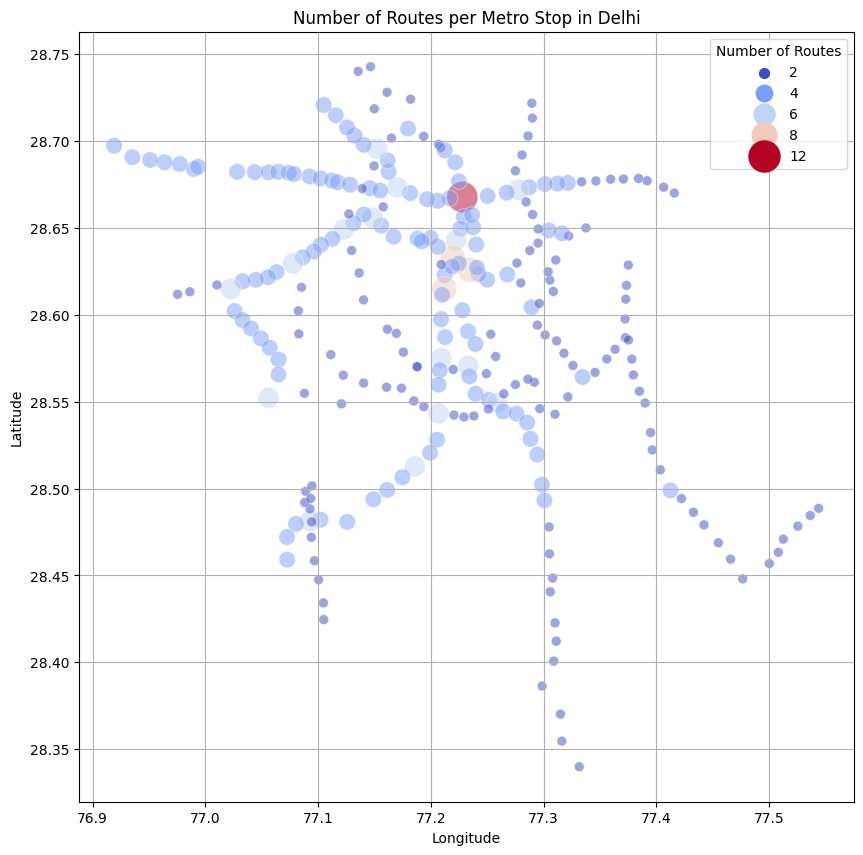

In [9]:
# merge stops with stop_times to link each stop with trips, and then merge with trips to get route information
stops_with_routes = pd.merge(pd.merge(stop_times, trips, on='trip_id'), routes, on='route_id')

# count how many unique routes pass through each stop
stop_route_counts = stops_with_routes.groupby('stop_id')['route_id'].nunique().reset_index()
stop_route_counts = stop_route_counts.rename(columns={'route_id': 'number_of_routes'})

# merge this with stops to get the names and location for plotting
stop_route_counts = pd.merge(stop_route_counts, stops, on='stop_id')

# plot the number of routes per stop
plt.figure(figsize=(10, 10))
sns.scatterplot(x='stop_lon', y='stop_lat', size='number_of_routes', hue='number_of_routes',
                sizes=(50, 500), alpha=0.5, palette='coolwarm', data=stop_route_counts)
plt.title('Number of Routes per Metro Stop in Delhi')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Number of Routes')
plt.grid(True)
plt.show()

1. Larger circles (in warmer colours) indicate stops where multiple routes intersect. These stops serve as major transfer points within the network, facilitating easier cross-city travel for passengers.
2. Stops with fewer routes, shown in cooler colours and smaller sizes, tend to be more peripheral or on less busy lines. The central areas and more populated zones have stops with greater connectivity.

In [10]:
# converting stop_times 'arrival_time' from string to datetime.time for easier manipulation
import datetime as dt

# function to convert time string to datetime.time
def convert_to_time(time_str):
    try:
        return dt.datetime.strptime(time_str, '%H:%M:%S').time()
    except ValueError:
        # Handle cases where the hour might be greater than 23 (e.g., 24:00:00 or 25:00:00)
        hour, minute, second = map(int, time_str.split(':'))
        return dt.time(hour % 24, minute, second)

stop_times['arrival_time_dt'] = stop_times['arrival_time'].apply(convert_to_time)

In [11]:
# calculate the difference in arrival times for subsequent trips at each stop
stop_times_sorted = stop_times.sort_values(by=['stop_id', 'arrival_time_dt'])
stop_times_sorted['next_arrival_time'] = stop_times_sorted.groupby('stop_id')['arrival_time_dt'].shift(-1)

# function to calculate the difference in minutes between two times
def time_difference(time1, time2):
    if pd.isna(time1) or pd.isna(time2):
        return None
    full_date_time1 = dt.datetime.combine(dt.date.today(), time1)
    full_date_time2 = dt.datetime.combine(dt.date.today(), time2)
    return (full_date_time2 - full_date_time1).seconds / 60

stop_times_sorted['interval_minutes'] = stop_times_sorted.apply(lambda row: time_difference(row['arrival_time_dt'], row['next_arrival_time']), axis=1)


In [12]:
# drop NaN values from intervals (last trip of the day)
stop_times_intervals = stop_times_sorted.dropna(subset=['interval_minutes'])

# average intervals by time of day (morning, afternoon, evening)
def part_of_day(time):
    if time < dt.time(12, 0):
        return 'Morning'
    elif time < dt.time(17, 0):
        return 'Afternoon'
    else:
        return 'Evening'

stop_times_intervals['part_of_day'] = stop_times_intervals['arrival_time_dt'].apply(part_of_day)
average_intervals = stop_times_intervals.groupby('part_of_day')['interval_minutes'].mean().reset_index()

/var/folders/zb/zcn5njgs1wd_d63974z2s2g40000gn/T/ipykernel_11608/1388039681.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_times_intervals['part_of_day'] = stop_times_intervals['arrival_time_dt'].apply(part_of_day)


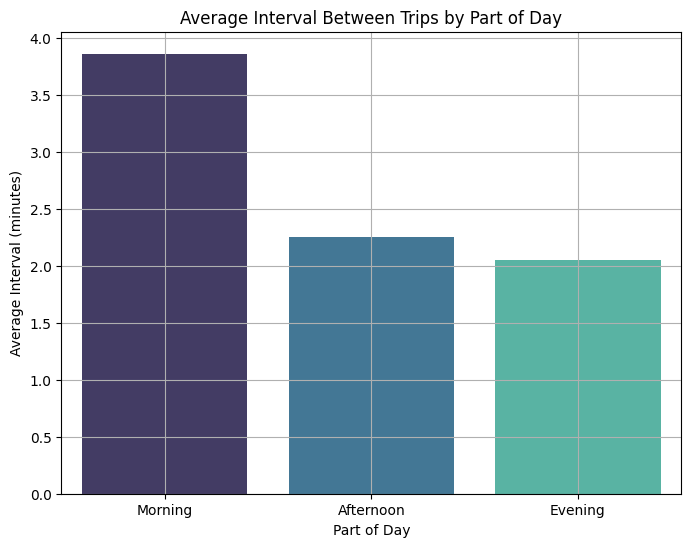

In [13]:
plt.figure(figsize=(8, 6))
sns.barplot(x='part_of_day', y='interval_minutes', data=average_intervals, order=['Morning', 'Afternoon', 'Evening'], palette='mako')
plt.title('Average Interval Between Trips by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Average Interval (minutes)')
plt.grid(True)
plt.show()

1. Shorter intervals between trips are observed in the morning hours, which likely corresponds to the morning rush hour when commuters are heading to work or school.
2. The intervals increase slightly during the afternoon, which may indicate a reduction in demand after the morning peak.
3. In the evening, intervals decrease again, likely to accommodate the evening rush hour as people return home.

Classifying the intervals:
1. Early Morning: Before 6 AM
2. Morning Peak: 6 AM to 10 AM
3. Midday: 10 AM to 4 PM
4. Evening Peak: 4 PM to 8 PM
5. Late Evening: After 8 PM

In [14]:
# define time intervals for classification
def classify_time_interval(time):
    if time < dt.time(6, 0):
        return 'Early Morning'
    elif time < dt.time(10, 0):
        return 'Morning Peak'
    elif time < dt.time(16, 0):
        return 'Midday'
    elif time < dt.time(20, 0):
        return 'Evening Peak'
    else:
        return 'Late Evening'

# apply time interval classification
stop_times['time_interval'] = stop_times['arrival_time_dt'].apply(classify_time_interval)

In [15]:
# count the number of trips per time interval
trips_per_interval = stop_times.groupby('time_interval')['trip_id'].nunique().reset_index()
trips_per_interval = trips_per_interval.rename(columns={'trip_id': 'number_of_trips'})

In [16]:
# sorting the dataframe
ordered_intervals = ['Early Morning', 'Morning Peak', 'Midday', 'Evening Peak', 'Late Evening']
trips_per_interval['time_interval'] = pd.Categorical(trips_per_interval['time_interval'], categories=ordered_intervals, ordered=True)
trips_per_interval = trips_per_interval.sort_values('time_interval')

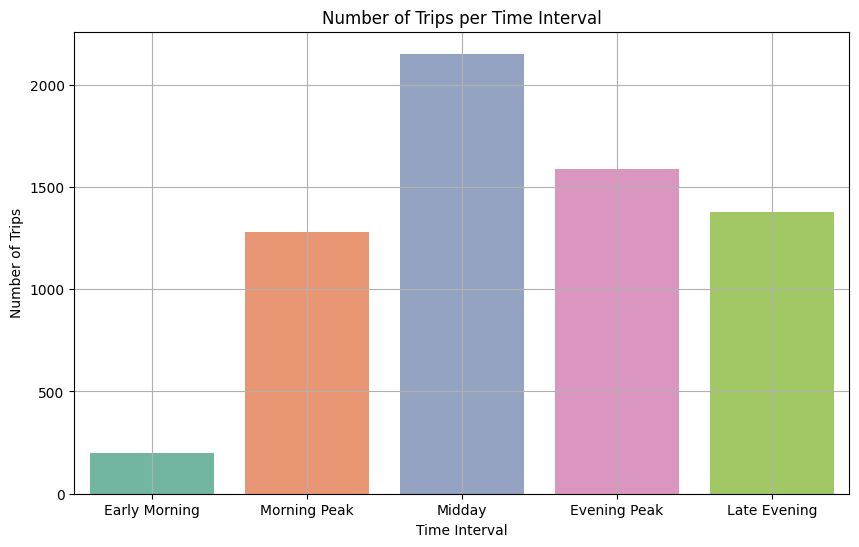

In [17]:
# plotting the number of trips per time interval
plt.figure(figsize=(10, 6))
sns.barplot(x='time_interval', y='number_of_trips', data=trips_per_interval, palette='Set2')
plt.title('Number of Trips per Time Interval')
plt.xlabel('Time Interval')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()

1. Early Morning: There is a relatively low number of trips, indicating less demand or fewer scheduled services during these hours.
2. Morning Peak: There is a significant increase in the number of trips compared to the early morning, likely due to morning commute hours as people travel to work or school.
3. Midday: The number of trips remains high, perhaps sustaining the morning rush or due to other midday travel needs.
4. Evening Peak: This period sees a slight decrease compared to midday but remains one of the busier times, probably reflecting the evening commute.
5. Late Evening: The number of trips drops again, but remains higher than in the early morning, likely catering to people returning home late or involved in evening activities.

In [18]:
# adjusting frequencies based on hypothetical scenario
adjusted_trips_per_interval = trips_per_interval.copy()
adjustment_factors = {'Morning Peak': 1.20, 'Evening Peak': 1.20, 'Midday': 0.90, 'Early Morning': 1.0, 'Late Evening': 0.90}

In [19]:
# apply the adjustments
adjusted_trips_per_interval['adjusted_number_of_trips'] = adjusted_trips_per_interval.apply(
    lambda row: int(row['number_of_trips'] * adjustment_factors[row['time_interval']]), axis=1)

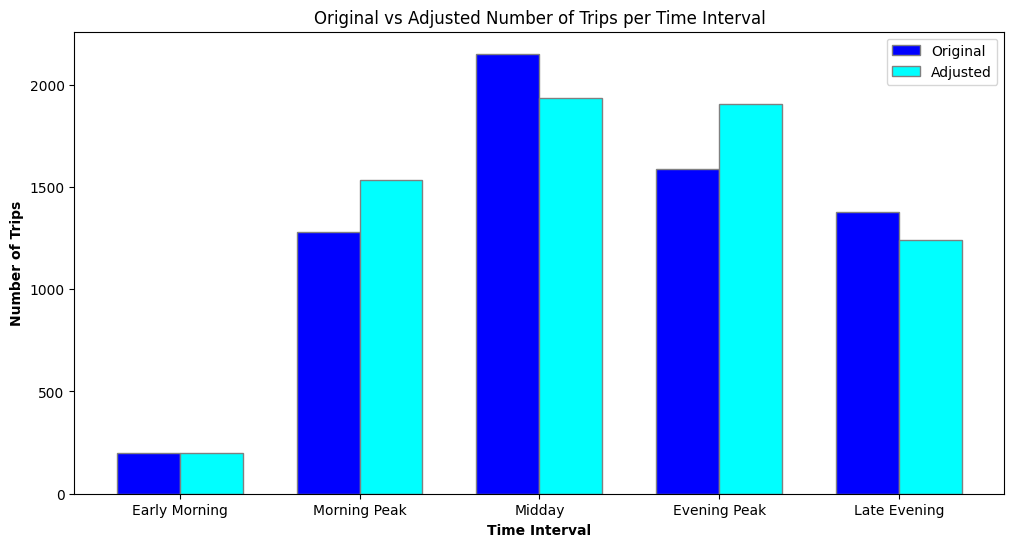

In [20]:
# plotting original vs adjusted number of trips per time interval
plt.figure(figsize=(12, 6))
bar_width = 0.35
r1 = range(len(adjusted_trips_per_interval))
r2 = [x + bar_width for x in r1]

plt.bar(r1, adjusted_trips_per_interval['number_of_trips'], color='blue', width=bar_width, edgecolor='grey', label='Original')
plt.bar(r2, adjusted_trips_per_interval['adjusted_number_of_trips'], color='cyan', width=bar_width, edgecolor='grey', label='Adjusted')

plt.xlabel('Time Interval', fontweight='bold')
plt.ylabel('Number of Trips', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(adjusted_trips_per_interval))], adjusted_trips_per_interval['time_interval'])
plt.title('Original vs Adjusted Number of Trips per Time Interval')
plt.legend()

plt.show()

1. Morning and Evening Peaks: We increased the number of trips by 20%, anticipating higher demand during these hours. This adjustment aims to reduce overcrowding and improve passenger comfort and service reliability.
2. Midday and Late Evening: We decreased the trips by 10%, assuming that the demand drops during these times, allowing for more efficient use of resources without significantly impacting service quality.